# Feature Engeneering

## Data loading/Загрузка данных

In [51]:
import os
from statistics import LinearRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [52]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style("whitegrid")
np.random.seed(42)

In [53]:
DATA_PATH = "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [54]:
if os.path.exists(DATA_PATH):
    data = pd.read_csv(DATA_PATH)
    print(f"Данные загружены: {data.shape[0]} строк, {data.shape[1]} столбцов")
else:
    raise FileNotFoundError(f"Файл {DATA_PATH} не найден!")

Данные загружены: 7043 строк, 21 столбцов


In [55]:
# TotalCharges сильно коррелирует с tenure
# мы ее можем восстановить MonthlyCharges x tenure, поэтому избавимся от данного признака
data = data.drop("TotalCharges", axis=1)

In [56]:
# Анализ показал, что новые клиенты уходят чаще
# Создадим бинарный признак "новый клиент"
# data["IsNewCustomer"] = (data["tenure"] < 12).astype(int)

In [57]:
# Приведем все сервисы к бинарному виду
# и создадим признак с количеством подключенных сервисов
service_cols = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies"
]

for col in service_cols:
    data[col] = data[col].replace("No internet service", "No")
    data[col] = (data[col] == "Yes").astype(int)



Новые признаки (например, NumServices) были добавлены на основе
выводов EDA и логической интерпретации данных.
Отдельная модельная валидация влияния каждого признака
не проводилась на данном этапе и может быть выполнена далее
в рамках улучшения модели.


In [58]:
# удалим признаки
drop_col = ["gender", "PhoneService", "MultipleLines", "customerID"]
data = data.drop(drop_col, axis=1)


In [59]:
#переведем бинарные признаки в численный тип
binary_cols = ["Partner", "Dependents", "PaperlessBilling", "Churn"]
for col in binary_cols:
    data[col] = data[col].map({"Yes": 1, "No": 0})

In [60]:
categorical_col = ["InternetService", "Contract", "PaymentMethod"]
data = pd.get_dummies(data, columns=categorical_col, drop_first=True)

data.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,0,0,0,0,1,29.85,0,False,False,False,False,False,True,False
1,0,0,0,34,1,0,1,0,0,0,0,56.95,0,False,False,True,False,False,False,True
2,0,0,0,2,1,1,0,0,0,0,1,53.85,1,False,False,False,False,False,False,True
3,0,0,0,45,1,0,1,1,0,0,0,42.30,0,False,False,True,False,False,False,False
4,0,0,0,2,0,0,0,0,0,0,1,70.70,1,True,False,False,False,False,True,False


In [61]:
print("Признаки, которые мы берем в модель:")
for col in data.columns:
    print(col)

Признаки, которые мы берем в модель:
SeniorCitizen
Partner
Dependents
tenure
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
PaperlessBilling
MonthlyCharges
Churn
InternetService_Fiber optic
InternetService_No
Contract_One year
Contract_Two year
PaymentMethod_Credit card (automatic)
PaymentMethod_Electronic check
PaymentMethod_Mailed check


## BaseLine модель

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,  classification_report, roc_curve

In [63]:
X = data.drop("Churn", axis=1)
y = data["Churn"]

# проверим баланс классов
print(f"Распределение классов:\n{y.value_counts(normalize=True)}")
print(f"Баланс классов:{y.value_counts(normalize=True)[1]:.1%} оттока")

Распределение классов:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Баланс классов:26.5% оттока


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # разделяем с сохранением распределения классов

print(f"Размер train выборки: {X_train.shape}")
print(f"Размер test выборки: {X_test.shape}")
print(f"Отток в train: {y_train.mean():.1%}")
print(f"Отток в test: {y_test.mean():.1%}")

Размер train выборки: (5634, 19)
Размер test выборки: (1409, 19)
Отток в train: 26.5%
Отток в test: 26.5%


In [65]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc = None

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    print("\n📈 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    if roc:
        print(f"\n🎯 ROC-AUC Score: {roc:.4f}")
    return roc

In [71]:
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)

print("Logistic Regression:")
roc_lr = evaluate_model(log_reg, X_train, X_test, y_train, y_test)

print("=" * 50)

print('Random Forest:')
roc_rf = evaluate_model(rf, X_train, X_test, y_train, y_test)

Logistic Regression:

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87      1035
       Churn       0.64      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409


📈 Confusion Matrix:
[[923 112]
 [174 200]]

🎯 ROC-AUC Score: 0.8382
Random Forest:

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.88      0.85      1035
       Churn       0.60      0.48      0.53       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409


📈 Confusion Matrix:
[[913 122]
 [193 181]]

🎯 ROC-AUC Score: 0.8186


In [87]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": log_reg.coef_[0],
}).sort_values(by="coef", ascending=False)

coef_df

,feature,coef
12,InternetService_Fiber optic,0.556670
10,PaperlessBilling,0.187298
9,StreamingMovies,0.186501
8,StreamingTV,0.185203
17,PaymentMethod_Electronic check,0.183727
0,SeniorCitizen,0.062127
18,PaymentMethod_Mailed check,0.039142
6,DeviceProtection,0.019601
1,Partner,0.014655
16,PaymentMethod_Credit card (automatic),-0.016606


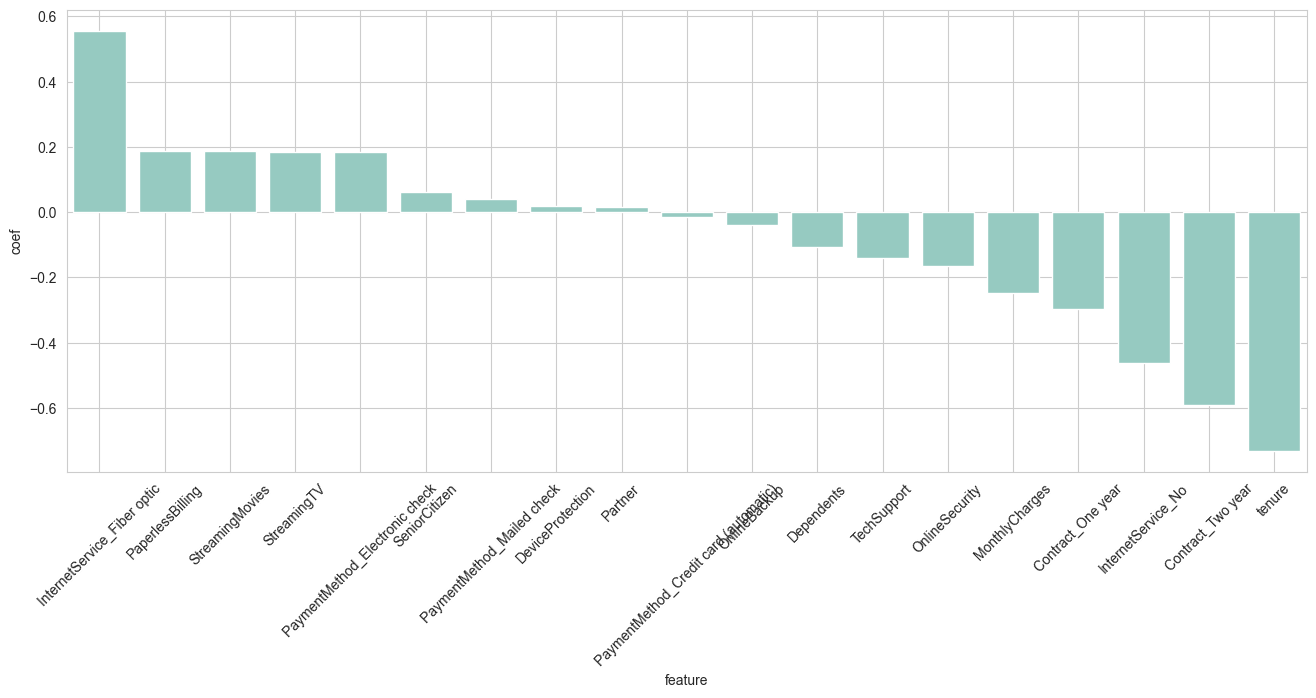

In [86]:
plt.figure(figsize=(16, 6))
sns.barplot(coef_df, x="feature", y="coef")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Коэффициенты логистической регрессии выявляют несколько сильных факторов оттока клиентов.

Наиболее значимым положительным фактором является оптоволоконный интернет, указывающий на более высокие показатели оттока среди этих клиентов.

Сервисы стриминга и электронные способы оплаты также демонстрируют умеренную положительную связь с оттоком.

Напротив, стаж работы с клиентом и долгосрочные контракты являются наиболее сильными защитными факторами, существенно снижающими вероятность оттока.

Дополнительные услуги поддержки, такие как онлайн безопасность и тех. поддержка, также способствуют улучшению удержания клиентов.

Эти результаты подчеркивают, что продолжительность контракта и стабильность обслуживания являются ключевыми рычагами снижения оттока.

In [91]:
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_,
}).sort_values(by="importance", ascending=False)

importance_df.head(10)

,feature,importance
11,MonthlyCharges,0.271484
3,tenure,0.258559
12,InternetService_Fiber optic,0.047422
17,PaymentMethod_Electronic check,0.047295
15,Contract_Two year,0.037649
10,PaperlessBilling,0.030370
14,Contract_One year,0.029915
1,Partner,0.029304
4,OnlineSecurity,0.028913
7,TechSupport,0.028666


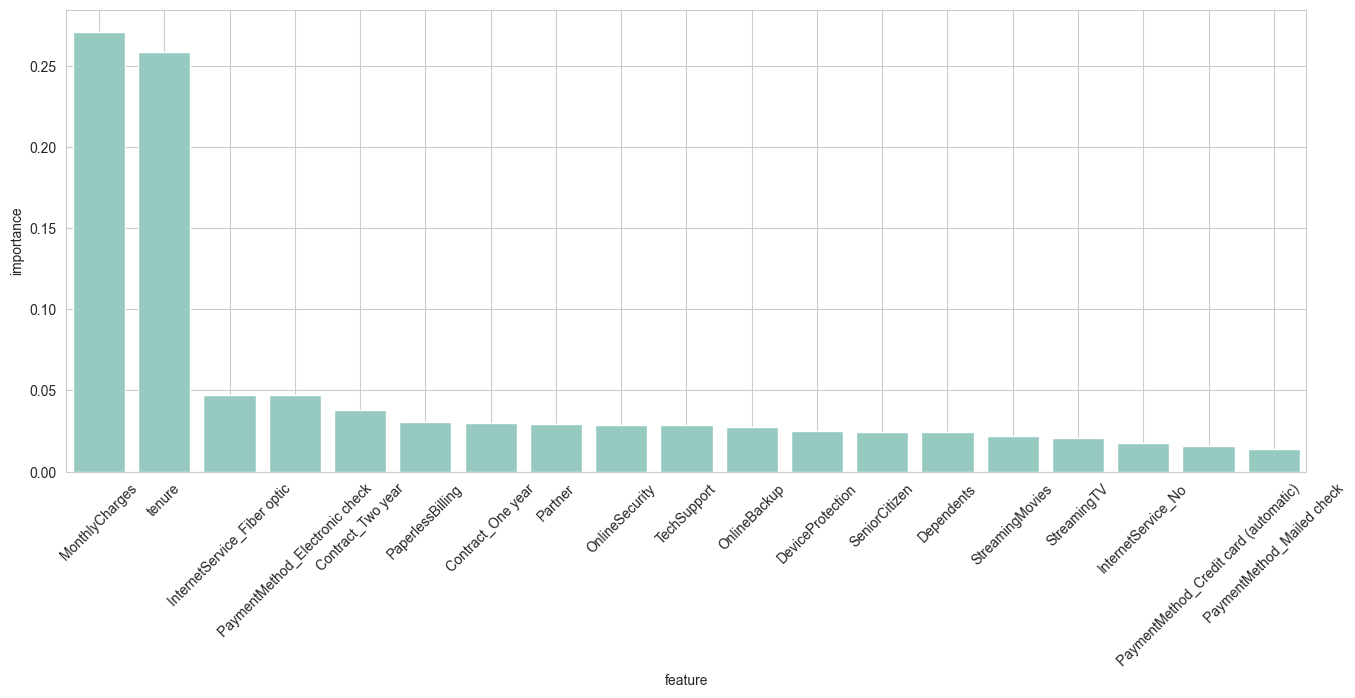

In [93]:
plt.figure(figsize=(16, 6))
sns.barplot(importance_df, x="feature", y="importance")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Feature Engeneering